In [ ]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict

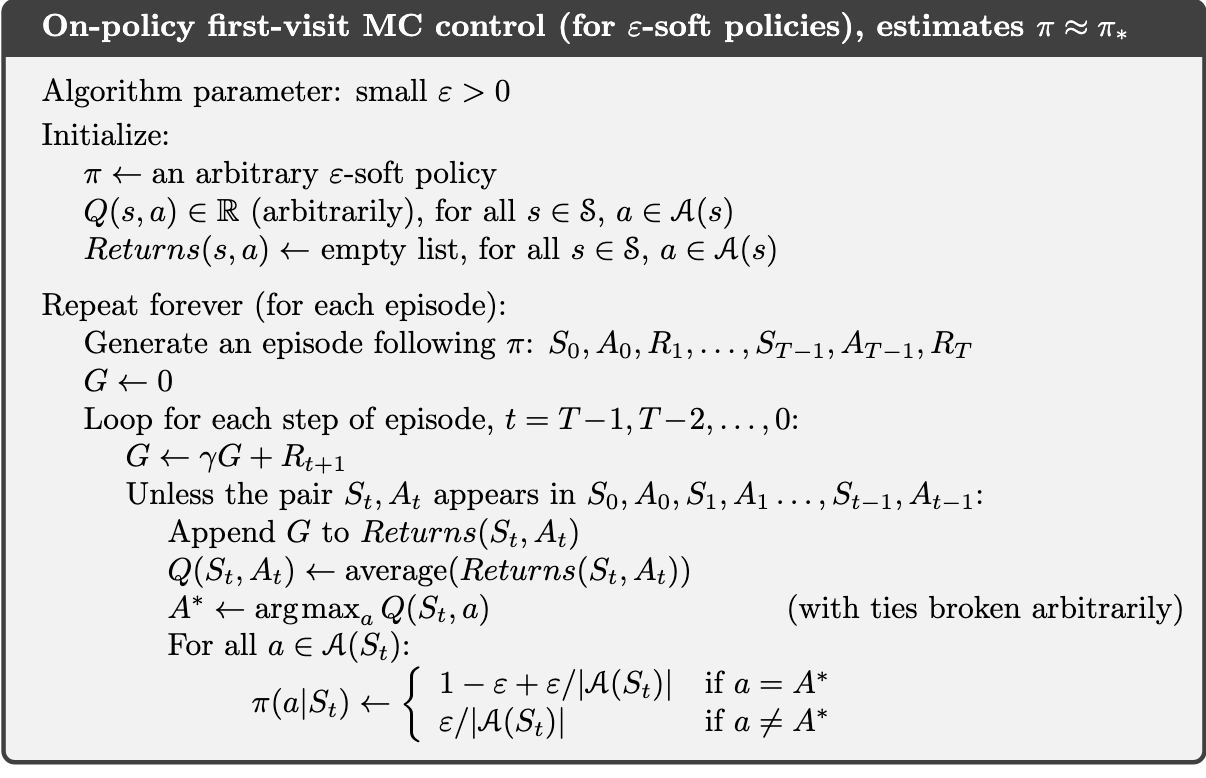


In [ ]:
def MC_control(env, eps=0.5, discount_factor=1.0, episodes=10000, max_t=None):
    nS = env.observation_space.n   # number of states
    nA = env.action_space.n        # number of actions

    # storage for returns and counts (for averaging)
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    Q = defaultdict(lambda: np.zeros(nA))  # action-value function

    policy = np.ones((nS, nA)) / nA        # start with uniform random policy

    for i in range(episodes):

        # generate one episode following current policy
        episode = []
        state, _ = env.reset()
        steps = 0
        while True:
            action = np.random.choice(nA, p=policy[state])
            s_next, reward, term, trun, _ = env.step(action)
            steps += 1
            episode.append((state, action, reward))
            if term or trun:
                break
            if max_t is not None and steps >= max_t:
                break
            state = s_next
        
        # record first-visit index for each (state, action)
        first_idxs = {}
        for idx, (s, a, _) in enumerate(episode):
            if (s, a) not in first_idxs:
                first_idxs[(s, a)] = idx
        
        # backward return calculation
        G = 0
        for t in reversed(range(len(episode))):
            s, a, r = episode[t]
            G = discount_factor * G + r
            if t == first_idxs[(s, a)]:  # only update on first visit
                returns_sum[(s, a)] += G
                returns_count[(s, a)] += 1.0
                Q[s][a] = returns_sum[(s, a)] / returns_count[(s, a)]
                
                # ε-greedy policy update
                best = np.random.choice(np.flatnonzero(Q[s] == Q[s].max()))
                policy[s] = np.full(nA, eps / nA)
                policy[s][best] += 1.0 - eps
    
    return policy, Q
